# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
#XVFB will be launched if you run on a server
import os
if os.environ.get("DISPLAY") is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

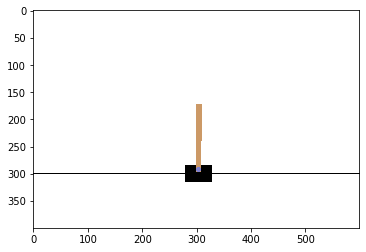

In [3]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (L.Dense) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [4]:
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Using TensorFlow backend.


In [5]:
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))

# let's create a network for approximate q-learning following guidelines above
###<YOUR CODE: stack more layers!!!1 >
network.add(L.Dense(100, activation='relu'))
network.add(L.Dense(100, activation='relu'))
network.add(L.Dense(n_actions, activation='linear'))

W1017 08:03:46.580272 140527103862528 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1017 08:03:46.581967 140527103862528 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1017 08:03:46.585141 140527103862528 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [6]:
import random

def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]
    
    ###YOUR CODE
    random_action = np.random.choice(n_actions)
    selected_action = np.argmax(q_values) if random.random() > epsilon \
                                          else random_action

    return selected_action

In [7]:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

W1017 08:03:46.653198 140527103862528 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1017 08:03:46.655904 140527103862528 deprecation_wrapper.py:119] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

In [8]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + state_dim)
actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])
rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])
next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + state_dim)
is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

In [9]:
#get q-values for all actions in current states
predicted_qvalues = network(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

In [10]:
gamma = 0.99

# compute q-values for all actions in next states
#<YOUR CODE - apply network to get q-values for next_states_ph>
predicted_next_qvalues = network(next_states_ph)

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

# compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
target_qvalues_for_actions = rewards_ph + gamma * next_state_values

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

W1017 08:03:57.840704 140527103862528 deprecation.py:323] From <ipython-input-10-658dd34f4276>:14: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
#mean squared error loss to minimize
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
loss = tf.reduce_mean(loss)

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [12]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

### Playing the game

In [13]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [14]:
epsilon = 0.5

In [15]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break

epoch #0	mean reward = 12.060	epsilon = 0.500
epoch #1	mean reward = 12.790	epsilon = 0.495
epoch #2	mean reward = 13.420	epsilon = 0.490
epoch #3	mean reward = 13.900	epsilon = 0.485
epoch #4	mean reward = 14.100	epsilon = 0.480
epoch #5	mean reward = 13.600	epsilon = 0.475
epoch #6	mean reward = 15.660	epsilon = 0.471
epoch #7	mean reward = 13.880	epsilon = 0.466
epoch #8	mean reward = 18.650	epsilon = 0.461
epoch #9	mean reward = 17.340	epsilon = 0.457
epoch #10	mean reward = 27.030	epsilon = 0.452
epoch #11	mean reward = 36.990	epsilon = 0.448
epoch #12	mean reward = 38.390	epsilon = 0.443
epoch #13	mean reward = 50.740	epsilon = 0.439
epoch #14	mean reward = 55.450	epsilon = 0.434
epoch #15	mean reward = 71.990	epsilon = 0.430
epoch #16	mean reward = 102.440	epsilon = 0.426
epoch #17	mean reward = 130.470	epsilon = 0.421
epoch #18	mean reward = 130.690	epsilon = 0.417
epoch #19	mean reward = 163.220	epsilon = 0.413
epoch #20	mean reward = 184.510	epsilon = 0.409
epoch #21	mean rew

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [16]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()


In [17]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

---

### Submit to coursera

In [18]:
from submit import submit_cartpole
submit_cartpole(generate_session, 'rajvirdhakhada7@gmail.com', 'LBpJXFTEjfYn14Qc')

Submitted to Coursera platform. See results on assignment page!
